In [2]:
import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json
from sklearn.mixture import GaussianMixture
import sklearn
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
az.style.use('arviz-darkgrid')

/Users/alseekford/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
df = pd.read_csv('Use_This.csv')

In [38]:
df.head()

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0        5038  202101200TOR  achiupr01        0  14:24             0   
1        5560  202101220TOR  achiupr01        0  11:32             0   
2       14277  202102240MIA  achiupr01        0   6:00             0   
3       42496  202110200TOR  achiupr01        1  18:30             0   
4       42647  202110220BOS  achiupr01        1  24:50             0   

   is_inactive  fantasy_points       player_name position team opponent  \
0            0            12.8  Precious Achiuwa        F  TOR      MIA   
1            0            10.7  Precious Achiuwa        F  TOR      MIA   
2            0             3.4  Precious Achiuwa        F  TOR      MIA   
3            0            18.4  Precious Achiuwa        F  TOR      WAS   
4            0            35.0  Precious Achiuwa        F  TOR      BOS   

   teamscore  opponentscore  date    avg_pts  
0        102            111   120  12.800000  
1        101             81   122  12.800000  
2        108            116   224  11.750000  
3         83             98  1020   8.966667  
4        115             83  1022  11.325000

In [9]:
# RANK
# Conditions
conditions = [
    (df['fantasy_points'] <= 0) & (df['avg_pts'] < 2),
    (df['fantasy_points'] > 0) & (df['fantasy_points'] < 3.3) & (df['avg_pts'] >= 2) & (df['avg_pts'] < 6.5),
    (df['fantasy_points'] >= 3.3) & (df['fantasy_points'] < 15.6) & (df['avg_pts'] >= 6.5) & (df['avg_pts'] < 16),
    (df['fantasy_points'] >= 15.6) & (df['fantasy_points'] < 27.5) & (df['avg_pts'] >= 16) & (df['avg_pts'] < 25), 
    (df['fantasy_points'] >= 27.5) & (df['fantasy_points'] < 100) & (df['avg_pts'] >= 25) & (df['avg_pts'] < 73)]

# Ranks
values = [0, 1, 2, 3, 4]

# Assign
df['rank'] = np.select(conditions, values)

In [ ]:
# IMPACT PLAYER
# Conditions
conditions = [
    (df['fantasy_points'] <= 0) & (df['avg_pts'] < 2),
    (df['fantasy_points'] > 0) & (df['fantasy_points'] < 3.3) & (df['avg_pts'] >= 2) & (df['avg_pts'] < 6.5),
    (df['fantasy_points'] >= 3.3) & (df['fantasy_points'] < 15.6) & (df['avg_pts'] >= 6.5) & (df['avg_pts'] < 16),
    (df['fantasy_points'] >= 15.6) & (df['fantasy_points'] < 27.5) & (df['avg_pts'] >= 16) & (df['avg_pts'] < 25), 
    (df['fantasy_points'] >= 27.5) & (df['fantasy_points'] < 100) & (df['avg_pts'] >= 25) & (df['avg_pts'] < 73)]

# Ranks
values = [0, 1, 2, 3, 4]

# Assign
df['rank'] = np.select(conditions, values)

# Testing out his Hierarchical Stuff

# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal (as prior on points?)
starter = df['starter']
# bernoulli

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

In [118]:
# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal
starter = df['starter']
# bernoulli

rank = df['rank']
# 

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

KeyError: 'rank'

In [11]:
test = []
for i in minutes:
    j = i.split(':')
    secs = int(j[1])
    if secs > 30:
        ans = int(j[0])
    else:
        ans = int(j[0]) + 1
    test.append(ans)

In [12]:
test2 = pd.factorize(df['opponent'])[0]+1

with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=npositions)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    
    # Linear model
    μ = a[position] + b[position]*test + c[position]*test2 + d[position]*avgpoints + e[position]*starter
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_x, sigma=sigma_x, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=200, step=pm.NUTS(target_accept=0.97), tune=500)

In [117]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_d, sigma=sigma_d, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)


Only 250 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, mu_c, mu_d, mu_e, mu_f, sigma_a, sigma_c, sigma_d, sigma_e, sigma_f, a, c, d, e, f, mu_x, sigma_x]


ValueError: Not enough samples to build a trace.

In [ ]:
# Variational inference with ADVI optimization
advi_hierarchical_fit = pm.fit(500, method='advi', model = hierarchical_model)

In [ ]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

In [ ]:
az.plot_trace(hierarchical_trace, var_names=['a','b','c','d','e'],compact =True)

In [ ]:
# plot the ELBO vs. fitting time or iterations (n)
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_hierarchical_fit.hist,
     'n': np.arange(advi_hierarchical_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [ ]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_hierarchical_sample = advi_hierarchical_fit.sample(PPC_SAMPLES)

# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['a'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['a'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [ ]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['b'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['b'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [ ]:
# Comparison Plots for intercepts

#burnin = 100

sample_intercept = hierarchical_trace.posterior['a'].mean(axis =0)
advi_intercept = advi_hierarchical_sample.posterior['a']


# Plot parameter posterior distributions


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), dpi=150, sharex=True)

for i, ax, level in zip(range(npositions), axes.ravel(), sorted(positions)):
    pm.plot_posterior(sample_intercept[:,i], ax=ax, point_estimate=None,  alpha=0.7)
    pm.plot_posterior(advi_intercept[0,:,i], ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    ax.set_title("Position: " + str(level), fontsize=12)
    
plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

In [ ]:
df

# Restarting

In [ ]:
df['diff_from_avg'] = df['fantasy_points'] - df['avg_pts']

In [ ]:
df['test2'] = pd.factorize(df['opponent'])[0]+1
df['test3'] = pd.factorize(df['team'])[0]+1

In [ ]:
one_hot_df = pd.get_dummies(df,columns=['position'])
one_hot_df.head()

import theano

num_positions=7
ranks=5
team_number = len(df['team'].unique())
np.random.seed(182)
train = one_hot_df

with pm.Model() as mdl:
    nu = pm.Exponential('nu minus one', 1/29.,shape=2) + 1 # from https://pymc-devs.github.io/pymc3/notebooks/BEST.html
    err = pm.Uniform('std dev based on rank', 0, 100, shape=ranks)
    err_b = pm.Uniform('std dev based on rank b', 0, 100, shape=ranks)

    # Theano shared variables to change at test time
    #player_home = theano.shared(np.asarray(train['is_home'].values, dtype = int))
    player_avg = theano.shared(np.asarray((train['avg_pts']).values, dtype = float))
    player_opp = theano.shared(np.asarray((train['test3']).values, dtype = int))
    player_team = theano.shared(np.asarray((train['test2']).values, dtype = int))
    player_rank = theano.shared(np.asarray((train['rank']).values, dtype = int))
    C = theano.shared(np.asarray((train['position_C']).values.astype(int), dtype = int))
    F = theano.shared(np.asarray((train['position_F']).values.astype(int), dtype = int))
    G = theano.shared(np.asarray((train['position_G']).values.astype(int), dtype = int))
    PF = theano.shared(np.asarray((train['position_PF']).values.astype(int), dtype = int))
    PG = theano.shared(np.asarray((train['position_PG']).values.astype(int), dtype = int))
    SF = theano.shared(np.asarray((train['position_SF']).values.astype(int), dtype = int))
    SG = theano.shared(np.asarray((train['position_SG']).values.astype(int), dtype = int))
    #pos_id = theano.shared(np.asarray((train['pos_code']).values, dtype = int))
    
    # Defensive ability of the opposing team vs. each position, partially pooled
    opp_def = pm.Normal('opp team prior',0, sigma=100**2, shape=num_positions)
    opp_C = pm.Normal('defensive differential c', opp_def[0], sigma=100**2, shape=team_number)
    opp_F = pm.Normal('defensive differential f', opp_def[1], sigma=100**2, shape=team_number)
    opp_G = pm.Normal('defensive differential g', opp_def[2], sigma=100**2, shape=team_number)
    opp_PF = pm.Normal('defensive differential pf', opp_def[3], sigma=100**2, shape=team_number)
    opp_PG = pm.Normal('defensive differential pg', opp_def[4], sigma=100**2, shape=team_number)
    opp_SF = pm.Normal('defensive differential sf', opp_def[5], sigma=100**2, shape=team_number)
    opp_SG = pm.Normal('defensive differential sg', opp_def[6], sigma=100**2, shape=team_number)
    
    # Partially pooled ability of the player's rank partially pooled based on position
    home_adv = pm.Normal('home additivie prior', 0, 100**2,shape = num_positions)     
    away_adv = pm.Normal('away additivie prior', 0, 100**2,shape = num_positions)     
    pos_home_C = pm.Normal('home differential c',home_adv[0],10**2, shape = ranks)
    pos_home_F = pm.Normal('home differential f',home_adv[1],10**2, shape = ranks)
    pos_home_G = pm.Normal('home differential g',home_adv[2],10**2, shape = ranks)
    pos_home_PF = pm.Normal('home differential pf',home_adv[3],10**2, shape = ranks)
    pos_home_PG = pm.Normal('home differential pg',home_adv[4],10**2, shape = ranks)
    pos_home_SF = pm.Normal('home differential sf',home_adv[5],10**2, shape = ranks)
    pos_home_SG = pm.Normal('home differential sg',home_adv[6],10**2, shape = ranks)
    
    pos_away_C = pm.Normal('away differential c',away_adv[0],10**2, shape = ranks)
    pos_away_F = pm.Normal('away differential f',away_adv[1],10**2, shape = ranks)
    pos_away_G = pm.Normal('away differential g',away_adv[2],10**2, shape = ranks)
    pos_away_PF = pm.Normal('away differential pf',away_adv[3],10**2, shape = ranks)
    pos_away_PG = pm.Normal('away differential pg',away_adv[4],10**2, shape = ranks)
    pos_away_SF = pm.Normal('away differential sf',away_adv[5],10**2, shape = ranks)
    pos_away_SG = pm.Normal('away differential sg',away_adv[6],10**2, shape = ranks)
    
    # First likelihood where the player's difference from average is explained by defensive abililty
    def_effect = C*opp_C[player_opp]+ F*opp_F[player_opp]+ G*opp_G[player_opp]+ PF*opp_PF[player_opp]+ PG*opp_PG[player_opp]+ SF*opp_SF[player_opp]+ SG*opp_SG[player_opp]
    like1 = pm.StudentT('Diff From Avg', mu=def_effect, sigma=err_b[player_rank],nu=nu[1], observed = train['diff_from_avg'])
    
    # Second likelihood where the score is predicted by defensive power plus other smaller factors
    #mu = player_avg + def_effect
    #mu += rb*pos_home_rb[player_rank]*(player_home) + wr*pos_home_wr[player_rank]*(player_home) 
    #mu += qb*pos_home_qb[player_rank]*(player_home) + te*pos_home_te[player_rank]*(player_home) 
    #mu += rb*pos_away_rb[player_rank]*(1-player_home) + wr*pos_away_wr[player_rank]*(1-player_home) 
    #mu += qb*pos_away_qb[player_rank]*(1-player_home) + te*pos_away_te[player_rank]*(1-player_home) 
    #like2 = pm.StudentT('Score', mu=mu, sd=err[player_rank], nu=nu[0], observed=train['score'])

    # Training!
    hierarchical_trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=1000)


# Team Effect on Position

with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_d, sigma=sigma_d, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

In [13]:
npositions = 7
with pm.Model() as model:
    
    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)

    # Define likelihood
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    likelihood = pm.Normal("y", mu=μ, sigma=sigma_x, observed=points)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #idata = pm.sample(3000)
    idraw = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

Only 250 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, mu_c, mu_d, mu_e, mu_f, sigma_a, sigma_c, sigma_d, sigma_e, sigma_f, a, c, d, e, f, mu_x, sigma_x]


Sampling 4 chains for 500 tune and 250 draw iterations (2_000 + 1_000 draws total) took 1700 seconds.


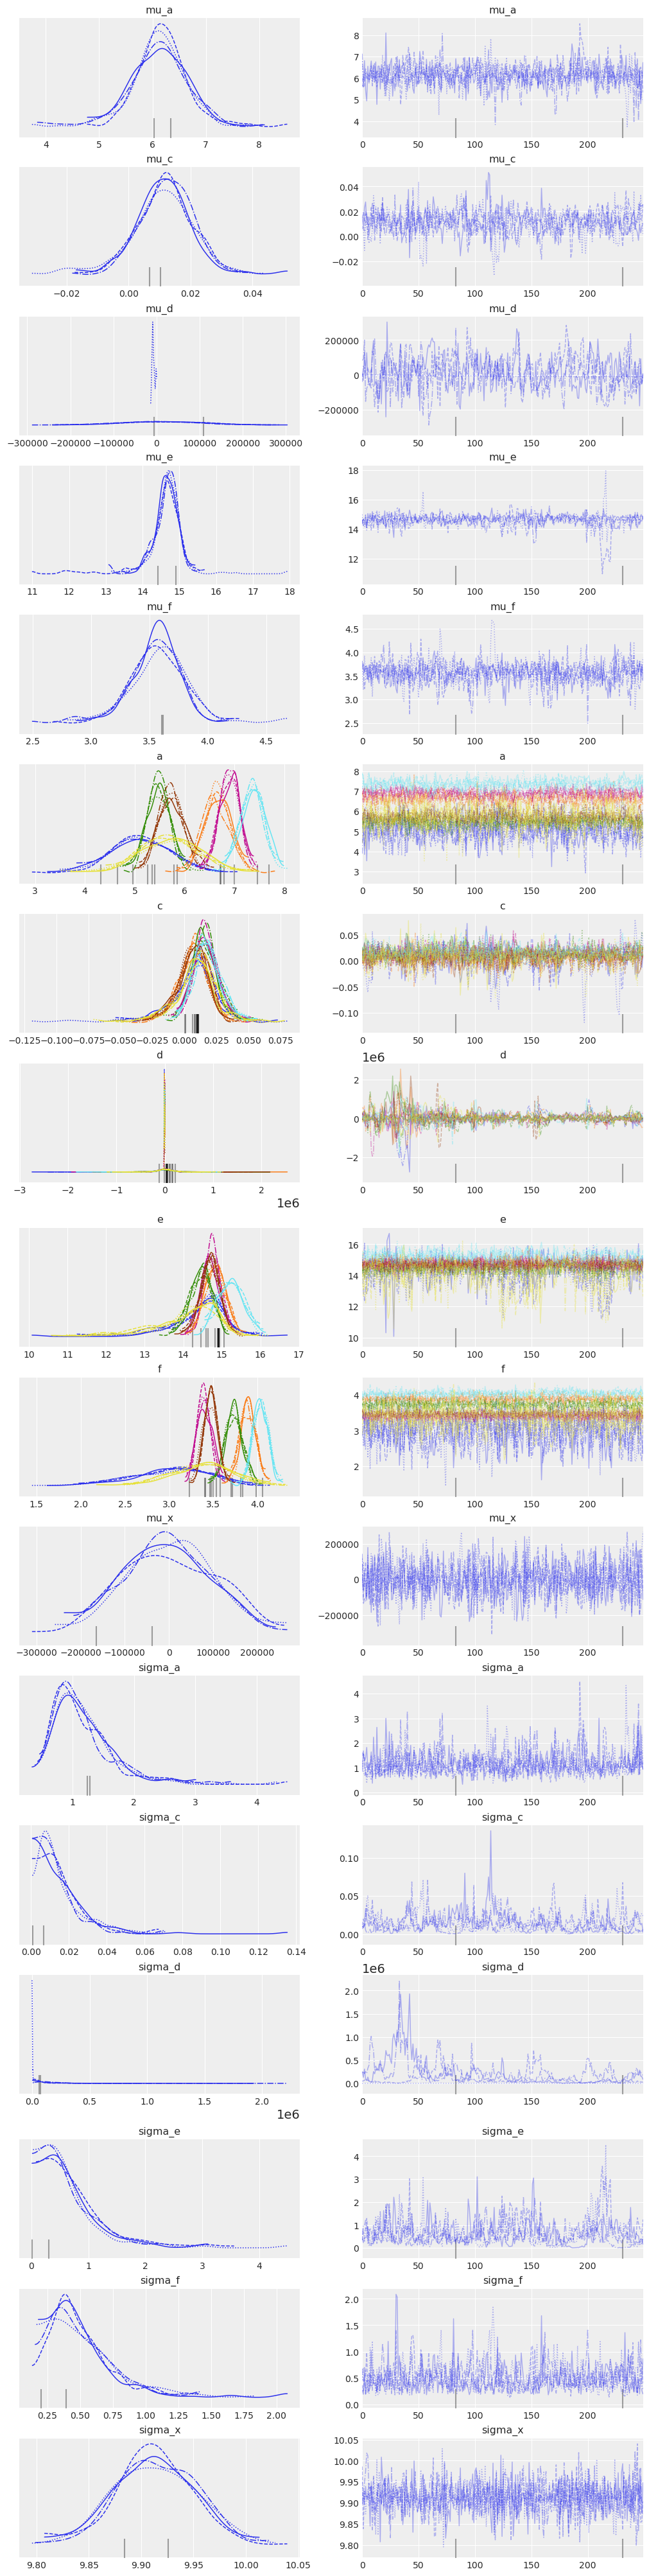

In [19]:
trace = az.plot_trace(idraw, figsize=(10, 40));

In [26]:
az.summary(idraw, var_names = ['a', 'c', 'e', 'f'], round_to = 2)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]   5.12  0.59    3.97     6.21       0.02     0.01    898.64    677.32   
a[1]   6.65  0.27    6.17     7.15       0.01     0.01    679.41    764.98   
a[2]   5.47  0.24    5.02     5.93       0.01     0.01    811.95    702.13   
a[3]   6.90  0.21    6.45     7.25       0.01     0.01    689.59    877.16   
a[4]   5.74  0.26    5.32     6.30       0.01     0.01    671.36    728.21   
a[5]   7.35  0.24    6.92     7.83       0.01     0.01    521.34    856.26   
a[6]   5.70  0.61    4.60     6.83       0.02     0.02    791.56    796.11   
c[0]   0.01  0.02   -0.03     0.04       0.00     0.00    551.45    358.64   
c[1]   0.01  0.01   -0.02     0.03       0.00     0.00    461.96    668.91   
c[2]   0.02  0.01   -0.00     0.04       0.00     0.00    743.09    635.80   
c[3]   0.02  0.01   -0.00     0.04       0.00     0.00    654.49    781.46   
c[4]   0.01  0.01   -0.02     0.03       0.00     0.00    513.86    588.66   
c[5]   0.02  0.01   -0.00     0.04       0.00     0.00    558.30    590.26   
c[6]   0.01  0.02   -0.03     0.04       0.00     0.00    680.26    433.98   
e[0]  14.41  0.76   12.97    15.73       0.04     0.03    537.39    318.92   
e[1]  14.83  0.26   14.32    15.29       0.01     0.01   1068.84    651.92   
e[2]  14.45  0.29   13.88    14.93       0.02     0.01    329.16    735.42   
e[3]  14.72  0.23   14.32    15.16       0.01     0.00   1177.82    710.56   
e[4]  14.68  0.26   14.19    15.17       0.01     0.00   1413.18    834.84   
e[5]  15.23  0.33   14.66    15.84       0.02     0.02    221.97    659.10   
e[6]  14.12  0.84   12.32    15.40       0.06     0.04    212.86    480.44   
f[0]   3.02  0.43    2.16     3.72       0.01     0.01    944.05    871.57   
f[1]   3.89  0.09    3.72     4.07       0.00     0.00   1442.51    900.90   
f[2]   3.73  0.10    3.55     3.92       0.00     0.00   1352.41    776.92   
f[3]   3.39  0.08    3.25     3.55       0.00     0.00   1145.85    465.29   
f[4]   3.47  0.08    3.32     3.62       0.00     0.00   1456.64    973.93   
f[5]   4.03  0.09    3.88     4.20       0.00     0.00    682.89    861.05   
f[6]   3.37  0.34    2.76     4.03       0.01     0.01   1139.40    710.20   

      r_hat  
a[0]   1.00  
a[1]   1.01  
a[2]   1.01  
a[3]   1.00  
a[4]   1.00  
a[5]   1.00  
a[6]   1.00  
c[0]   1.01  
c[1]   1.01  
c[2]   1.01  
c[3]   1.01  
c[4]   1.01  
c[5]   1.00  
c[6]   1.01  
e[0]   1.01  
e[1]   1.00  
e[2]   1.00  
e[3]   1.01  
e[4]   1.00  
e[5]   1.00  
e[6]   1.01  
f[0]   1.00  
f[1]   1.00  
f[2]   1.00  
f[3]   1.01  
f[4]   1.00  
f[5]   1.00  
f[6]   1.00

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

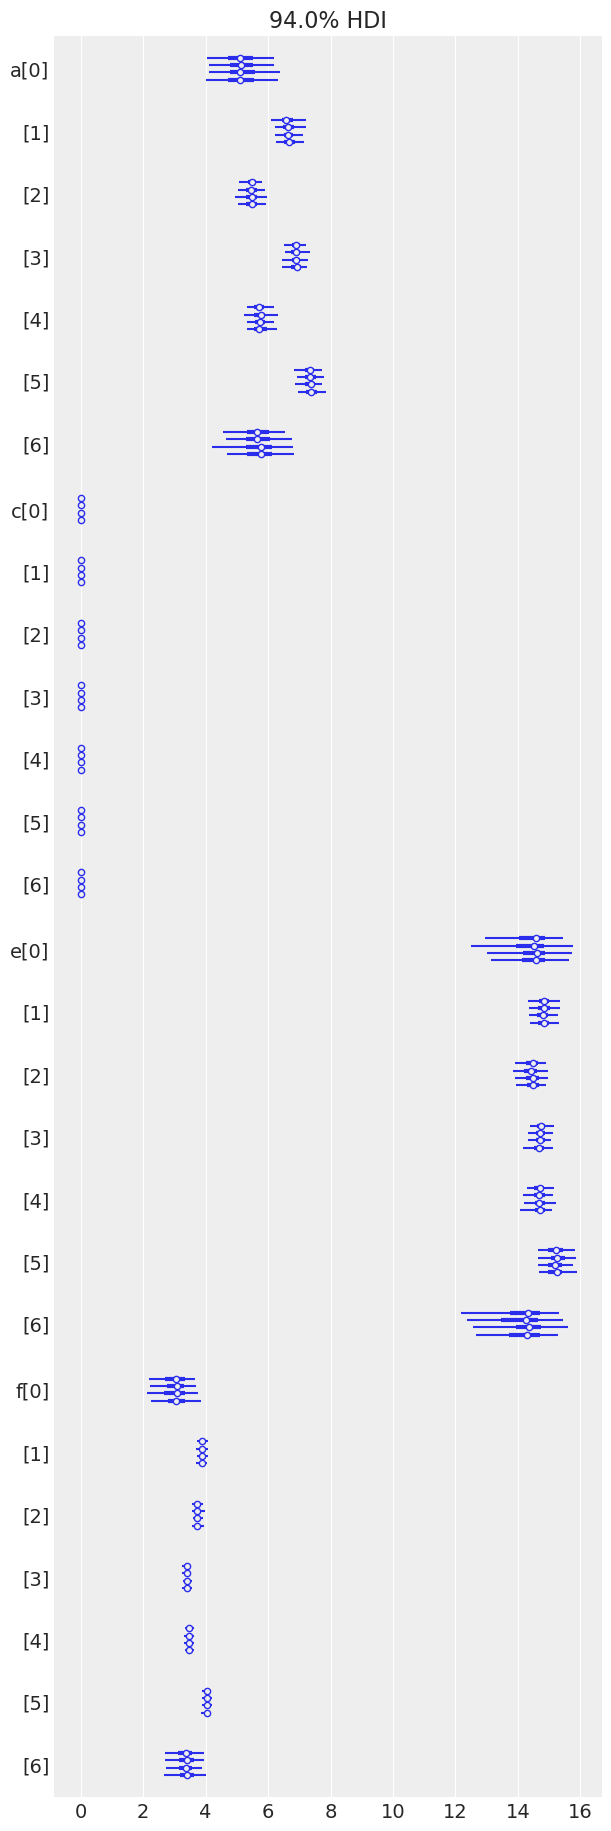

In [27]:
pm.plot_forest(idraw, var_names=['a', 'c', 'e', 'f'])

In [36]:
one_hot_df

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0            5038  202101200TOR  achiupr01        0  14:24             0   
1            5560  202101220TOR  achiupr01        0  11:32             0   
2           14277  202102240MIA  achiupr01        0   6:00             0   
3           42496  202110200TOR  achiupr01        1  18:30             0   
4           42647  202110220BOS  achiupr01        1  24:50             0   
...           ...           ...        ...      ...    ...           ...   
30829       53979  202112200LAC  zubaciv01        1  27:21             0   
30830       54290  202112220SAC  zubaciv01        1  26:39             0   
30831       54770  202112260LAC  zubaciv01        1  27:22             0   
30832       54968  202112270LAC  zubaciv01        1  21:45             0   
30833       55295  202112290BOS  zubaciv01        1  30:43             0   

       is_inactive  fantasy_points       player_name team  ... diff_from_avg  \
0                0            12.8  Precious Achiuwa  TOR  ...      0.000000   
1                0            10.7  Precious Achiuwa  TOR  ...     -2.100000   
2                0             3.4  Precious Achiuwa  TOR  ...     -8.350000   
3                0            18.4  Precious Achiuwa  TOR  ...      9.433333   
4                0            35.0  Precious Achiuwa  TOR  ...     23.675000   
...            ...             ...               ...  ...  ...           ...   
30829            0            31.9       Ivica Zubac  LAC  ...     10.930000   
30830            0            22.2       Ivica Zubac  LAC  ...     -0.980000   
30831            0            36.2       Ivica Zubac  LAC  ...     13.440000   
30832            0            19.3       Ivica Zubac  LAC  ...     -4.830000   
30833            0            19.3       Ivica Zubac  LAC  ...     -3.690000   

       test2  test3  position_C  position_F  position_G  position_PF  \
0          1      1           0           1           0            0   
1          1      1           0           1           0            0   
2          1      1           0           1           0            0   
3          2      1           0           1           0            0   
4          3      1           0           1           0            0   
...      ...    ...         ...         ...         ...          ...   
30829     29     21           1           0           0            0   
30830     12     21           1           0           0            0   
30831     20     21           1           0           0            0   
30832     10     21           1           0           0            0   
30833      3     21           1           0           0            0   

       position_PG  position_SF  position_SG  
0                0            0            0  
1                0            0            0  
2                0            0            0  
3                0            0            0  
4                0            0            0  
...            ...          ...          ...  
30829            0            0            0  
30830            0            0            0  
30831            0            0            0  
30832            0            0            0  
30833            0            0            0  

[30834 rows x 27 columns]

In [46]:
df

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0            5038  202101200TOR  achiupr01        0  14:24             0   
1            5560  202101220TOR  achiupr01        0  11:32             0   
2           14277  202102240MIA  achiupr01        0   6:00             0   
3           42496  202110200TOR  achiupr01        1  18:30             0   
4           42647  202110220BOS  achiupr01        1  24:50             0   
...           ...           ...        ...      ...    ...           ...   
30829       53979  202112200LAC  zubaciv01        1  27:21             0   
30830       54290  202112220SAC  zubaciv01        1  26:39             0   
30831       54770  202112260LAC  zubaciv01        1  27:22             0   
30832       54968  202112270LAC  zubaciv01        1  21:45             0   
30833       55295  202112290BOS  zubaciv01        1  30:43             0   

       is_inactive  fantasy_points       player_name position team opponent  \
0                0            12.8  Precious Achiuwa        F  TOR      MIA   
1                0            10.7  Precious Achiuwa        F  TOR      MIA   
2                0             3.4  Precious Achiuwa        F  TOR      MIA   
3                0            18.4  Precious Achiuwa        F  TOR      WAS   
4                0            35.0  Precious Achiuwa        F  TOR      BOS   
...            ...             ...               ...      ...  ...      ...   
30829            0            31.9       Ivica Zubac        C  LAC      SAS   
30830            0            22.2       Ivica Zubac        C  LAC      SAC   
30831            0            36.2       Ivica Zubac        C  LAC      DEN   
30832            0            19.3       Ivica Zubac        C  LAC      BRK   
30833            0            19.3       Ivica Zubac        C  LAC      BOS   

       teamscore  opponentscore  date    avg_pts  
0            102            111   120  12.800000  
1            101             81   122  12.800000  
2            108            116   224  11.750000  
3             83             98  1020   8.966667  
4            115             83  1022  11.325000  
...          ...            ...   ...        ...  
30829         92            116  1220  20.970000  
30830        105             89  1222  23.180000  
30831        100            103  1226  22.760000  
30832        108            124  1227  24.130000  
30833         91             82  1229  22.990000  

[30834 rows x 16 columns]

In [63]:

df['10_game_average_position']=df.groupby(['position', 'opponent', 'game_id']).fantasy_points.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))

In [68]:
df.query("team == 'TOR'")

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0            5038  202101200TOR  achiupr01        0  14:24             0   
1            5560  202101220TOR  achiupr01        0  11:32             0   
2           14277  202102240MIA  achiupr01        0   6:00             0   
3           42496  202110200TOR  achiupr01        1  18:30             0   
4           42647  202110220BOS  achiupr01        1  24:50             0   
...           ...           ...        ...      ...    ...           ...   
29355       52983  202112140BRK  watanyu01        0  27:24             0   
29356       53725  202112180TOR  watanyu01        0  21:09             0   
29357       54737  202112260CLE  watanyu01        1  37:10             0   
29358       55258  202112280TOR  watanyu01        1  31:28             0   
29359       55801  202112310TOR  watanyu01        0  13:22             0   

       is_inactive  fantasy_points       player_name position team opponent  \
0                0            12.8  Precious Achiuwa        F  TOR      MIA   
1                0            10.7  Precious Achiuwa        F  TOR      MIA   
2                0             3.4  Precious Achiuwa        F  TOR      MIA   
3                0            18.4  Precious Achiuwa        F  TOR      WAS   
4                0            35.0  Precious Achiuwa        F  TOR      BOS   
...            ...             ...               ...      ...  ...      ...   
29355            0            20.5     Yuta Watanabe       SF  TOR      BRK   
29356            0            21.8     Yuta Watanabe       SF  TOR      GSW   
29357            0            40.1     Yuta Watanabe       SF  TOR      CLE   
29358            0            15.8     Yuta Watanabe       SF  TOR      PHI   
29359            0             1.2     Yuta Watanabe       SF  TOR      LAC   

       teamscore  opponentscore  date    avg_pts  10_game_average  \
0            102            111   120  12.800000        12.800000   
1            101             81   122  12.800000        12.800000   
2            108            116   224  11.750000        11.750000   
3             83             98  1020   8.966667         8.966667   
4            115             83  1022  11.325000        11.325000   
...          ...            ...   ...        ...              ...   
29355        129            131  1214  11.220000        11.220000   
29356        119            100  1218  13.270000        13.270000   
29357         99            144  1226  15.450000        15.450000   
29358        109            114  1228  18.000000        18.000000   
29359        116            108  1231  18.890000        18.890000   

       10_game_average_position  
0                          12.8  
1                          10.7  
2                           3.4  
3                          18.4  
4                          35.0  
...                         ...  
29355                      42.9  
29356                      26.6  
29357                      40.1  
29358                      15.8  
29359                      40.2  

[750 rows x 18 columns]

In [62]:
df.query("team == 'TOR'").head()

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0        5038  202101200TOR  achiupr01        0  14:24             0   
1        5560  202101220TOR  achiupr01        0  11:32             0   
2       14277  202102240MIA  achiupr01        0   6:00             0   
3       42496  202110200TOR  achiupr01        1  18:30             0   
4       42647  202110220BOS  achiupr01        1  24:50             0   

   is_inactive  fantasy_points       player_name position team opponent  \
0            0            12.8  Precious Achiuwa        F  TOR      MIA   
1            0            10.7  Precious Achiuwa        F  TOR      MIA   
2            0             3.4  Precious Achiuwa        F  TOR      MIA   
3            0            18.4  Precious Achiuwa        F  TOR      WAS   
4            0            35.0  Precious Achiuwa        F  TOR      BOS   

   teamscore  opponentscore  date    avg_pts  10_game_average  \
0        102            111   120  12.800000        12.800000   
1        101             81   122  12.800000        12.800000   
2        108            116   224  11.750000        11.750000   
3         83             98  1020   8.966667         8.966667   
4        115             83  1022  11.325000        11.325000   

   10_game_average_position  
0                     12.80  
1                     12.80  
2                     11.75  
3                     18.40  
4                     35.00

In [ ]:
for row in df.index:
    c = df['game_id'][row]
    if c in set(names['player_id']):
        row_num = names[(names['player_id'] == c)].index
        b = names['player'][row_num]
        df['player_name'][row] = b

In [95]:
df

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
0            5038  202101200TOR  achiupr01        0  14:24             0   
1            5560  202101220TOR  achiupr01        0  11:32             0   
2           14277  202102240MIA  achiupr01        0   6:00             0   
3           42496  202110200TOR  achiupr01        1  18:30             0   
4           42647  202110220BOS  achiupr01        1  24:50             0   
...           ...           ...        ...      ...    ...           ...   
30829       53979  202112200LAC  zubaciv01        1  27:21             0   
30830       54290  202112220SAC  zubaciv01        1  26:39             0   
30831       54770  202112260LAC  zubaciv01        1  27:22             0   
30832       54968  202112270LAC  zubaciv01        1  21:45             0   
30833       55295  202112290BOS  zubaciv01        1  30:43             0   

       is_inactive  fantasy_points       player_name position team opponent  \
0                0            12.8  Precious Achiuwa        F  TOR      MIA   
1                0            10.7  Precious Achiuwa        F  TOR      MIA   
2                0             3.4  Precious Achiuwa        F  TOR      MIA   
3                0            18.4  Precious Achiuwa        F  TOR      WAS   
4                0            35.0  Precious Achiuwa        F  TOR      BOS   
...            ...             ...               ...      ...  ...      ...   
30829            0            31.9       Ivica Zubac        C  LAC      SAS   
30830            0            22.2       Ivica Zubac        C  LAC      SAC   
30831            0            36.2       Ivica Zubac        C  LAC      DEN   
30832            0            19.3       Ivica Zubac        C  LAC      BRK   
30833            0            19.3       Ivica Zubac        C  LAC      BOS   

       teamscore  opponentscore  date    avg_pts  10_game_average  \
0            102            111   120  12.800000        12.800000   
1            101             81   122  12.800000        12.800000   
2            108            116   224  11.750000        11.750000   
3             83             98  1020   8.966667         8.966667   
4            115             83  1022  11.325000        11.325000   
...          ...            ...   ...        ...              ...   
30829         92            116  1220  20.970000        20.970000   
30830        105             89  1222  23.180000        23.180000   
30831        100            103  1226  22.760000        22.760000   
30832        108            124  1227  24.130000        24.130000   
30833         91             82  1229  22.990000        22.990000   

       10_game_average_position  
0                          12.8  
1                          10.7  
2                           3.4  
3                          18.4  
4                          35.0  
...                         ...  
30829                      16.1  
30830                      23.5  
30831                      20.7  
30832                      16.1  
30833                       3.6  

[30834 rows x 18 columns]

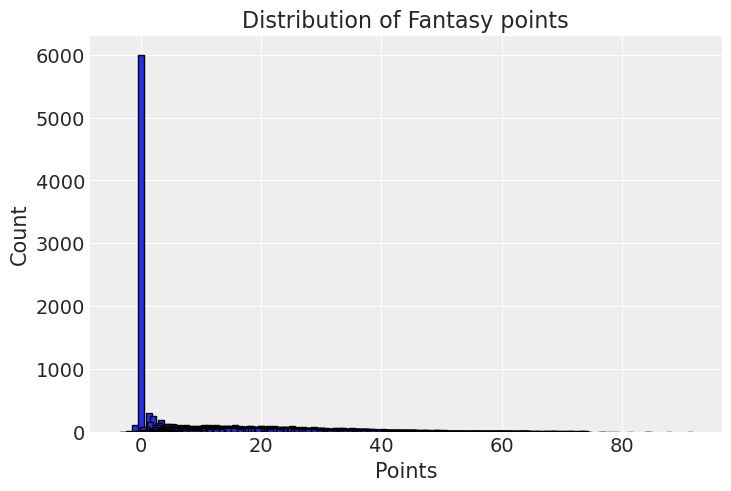

In [99]:






plt.bar(df['fantasy_points'].value_counts().index, 
        df['fantasy_points'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Points'); plt.ylabel('Count');
plt.title('Distribution of Fantasy points');

In [109]:
df = df.sort_values('date')
train = df.head(25000)
test = df.tail(5834)

In [113]:
train

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
7505           87  202101010DAL  doncilu01        1  35:49             0   
6790          233  202101010GSW  curryst01        1  33:38             0   
7974           36  202101010BRK  duranke01        1  37:28             0   
26388         244  202101010GSW  simonan01        0  22:07             0   
28649         347  202101010SAS  vassede01        0   0:00             1   
...           ...           ...        ...      ...    ...           ...   
8135        48604  202111200MIN  edwaran01        1  26:02             0   
4063        48569  202111200IND  brissos01        0   8:47             0   
16432       48675  202111200POR  korkmfu01        0  21:19             0   
14850       48678  202111200POR    joeis01        0   5:25             0   
16220       48619  202111200MIN  knighna01        0   8:55             0   

       is_inactive  fantasy_points      player_name position team opponent  \
7505             0            52.5      Luka Doncic       PG  DAL      MIA   
6790             0            42.1    Stephen Curry       PG  GSW      POR   
7974             0            44.6     Kevin Durant       PF  BRK      ATL   
26388            0            18.2  Anfernee Simons       SG  POR      GSW   
28649            0             0.0    Devin Vassell       SG  SAS      LAL   
...            ...             ...              ...      ...  ...      ...   
8135             0            25.0  Anthony Edwards       SF  MIN      MEM   
4063             0             1.4   Oshae Brissett       SF  IND      NOP   
16432            0             5.7   Furkan Korkmaz       SG  PHI      POR   
14850            0             4.5       Isaiah Joe       SG  PHI      POR   
16220            0            15.1    Nathan Knight        F  MIN      MEM   

       teamscore  opponentscore  date  avg_pts  10_game_average  \
7505          93             83   101    52.50            52.50   
6790          98            123   101    42.10            42.10   
7974          96            114   101    44.60            44.60   
26388        123             98   101    18.20            18.20   
28649        103            109   101     0.00             0.00   
...          ...            ...   ...      ...              ...   
8135         138             95  1120    35.79            35.79   
4063         111             94  1120     0.59             0.59   
16432        111            118  1120    19.41            19.41   
14850        111            118  1120     4.02             4.02   
16220        138             95  1120     0.54             0.54   

       10_game_average_position  position_code  
7505                      11.10              0  
6790                      42.10              0  
7974                      44.60              1  
26388                     21.35              2  
28649                      0.00              2  
...                         ...            ...  
8135                      25.00              3  
4063                       1.40              3  
16432                     10.20              2  
14850                     15.90              2  
16220                     15.10              5  

[25000 rows x 19 columns]

In [125]:
# Predictor variables
minutes = train['mp']
# normal
points = train['fantasy_points']
# normal
opponent = train['opponent']
# 
avgpoints = train['avg_pts']
# normal
starter = train['starter']
# bernoulli

# 





# grouping or hierarchical variable
positions = train['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = train["position_code"] = train.position.replace(position_lookup).values
test2 = pd.factorize(train['opponent'])[0]+1




/var/folders/wr/lczqjp8n7tg2kyz1cfv15szw0000gn/T/ipykernel_80274/1504077745.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position  = train["position_code"] = train.position.replace(position_lookup).values


In [126]:
train

Unnamed: 0       game_id  player_id  starter     mp  did_not_play  \
7505           87  202101010DAL  doncilu01        1  35:49             0   
6790          233  202101010GSW  curryst01        1  33:38             0   
7974           36  202101010BRK  duranke01        1  37:28             0   
26388         244  202101010GSW  simonan01        0  22:07             0   
28649         347  202101010SAS  vassede01        0   0:00             1   
...           ...           ...        ...      ...    ...           ...   
8135        48604  202111200MIN  edwaran01        1  26:02             0   
4063        48569  202111200IND  brissos01        0   8:47             0   
16432       48675  202111200POR  korkmfu01        0  21:19             0   
14850       48678  202111200POR    joeis01        0   5:25             0   
16220       48619  202111200MIN  knighna01        0   8:55             0   

       is_inactive  fantasy_points      player_name position team opponent  \
7505             0            52.5      Luka Doncic       PG  DAL      MIA   
6790             0            42.1    Stephen Curry       PG  GSW      POR   
7974             0            44.6     Kevin Durant       PF  BRK      ATL   
26388            0            18.2  Anfernee Simons       SG  POR      GSW   
28649            0             0.0    Devin Vassell       SG  SAS      LAL   
...            ...             ...              ...      ...  ...      ...   
8135             0            25.0  Anthony Edwards       SF  MIN      MEM   
4063             0             1.4   Oshae Brissett       SF  IND      NOP   
16432            0             5.7   Furkan Korkmaz       SG  PHI      POR   
14850            0             4.5       Isaiah Joe       SG  PHI      POR   
16220            0            15.1    Nathan Knight        F  MIN      MEM   

       teamscore  opponentscore  date  avg_pts  10_game_average  \
7505          93             83   101    52.50            52.50   
6790          98            123   101    42.10            42.10   
7974          96            114   101    44.60            44.60   
26388        123             98   101    18.20            18.20   
28649        103            109   101     0.00             0.00   
...          ...            ...   ...      ...              ...   
8135         138             95  1120    35.79            35.79   
4063         111             94  1120     0.59             0.59   
16432        111            118  1120    19.41            19.41   
14850        111            118  1120     4.02             4.02   
16220        138             95  1120     0.54             0.54   

       10_game_average_position  position_code  
7505                      11.10              0  
6790                      42.10              0  
7974                      44.60              1  
26388                     21.35              2  
28649                      0.00              2  
...                         ...            ...  
8135                      25.00              3  
4063                       1.40              3  
16432                     10.20              2  
14850                     15.90              2  
16220                     15.10              5  

[25000 rows x 19 columns]

In [128]:
npositions = 7
with pm.Model() as model:
    
    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)

    # Define likelihood
    μ = a[position] + c[position]*test2 + e[position]*starter
    likelihood = pm.Normal("y", mu=μ, sigma=sigma_x, observed=points)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #idata = pm.sample(3000)
    idraw = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

Only 250 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, mu_c, mu_d, mu_e, sigma_a, sigma_c, sigma_d, sigma_e, a, c, d, e, mu_x, sigma_x]


Sampling 4 chains for 500 tune and 250 draw iterations (2_000 + 1_000 draws total) took 808 seconds.


In [132]:
x_test = test.drop('fantasy_points', axis=1)

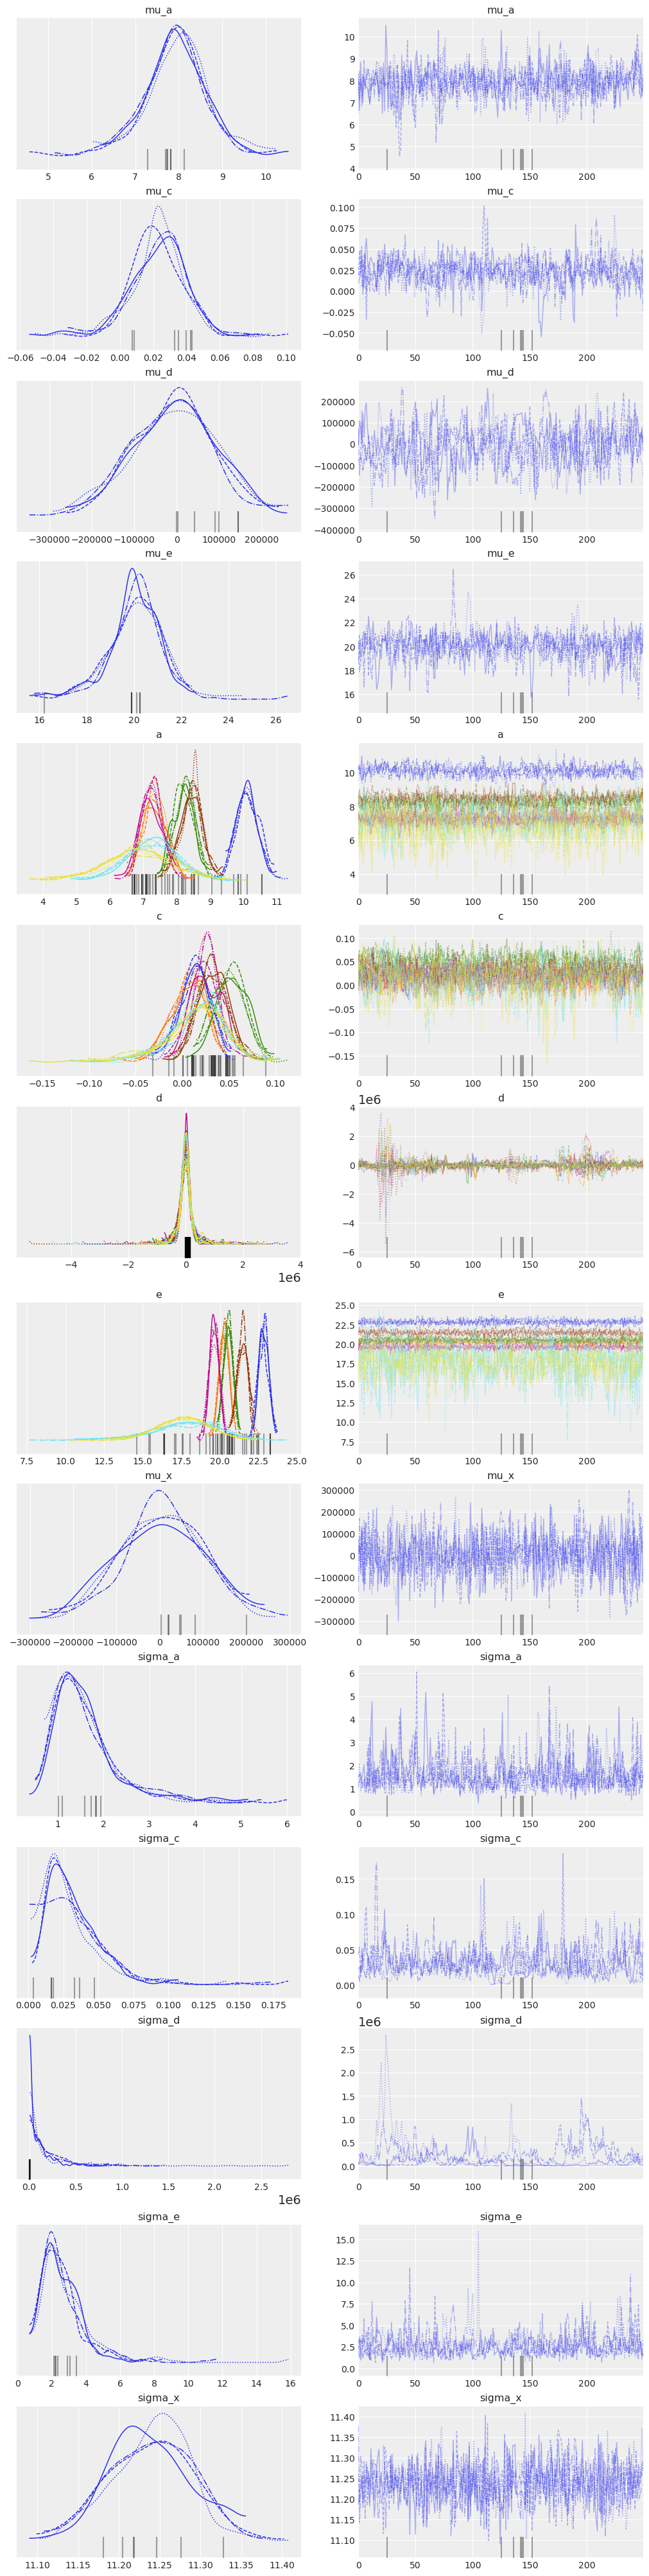

In [137]:
trace = az.plot_trace(idraw, figsize=(10, 40));

In [139]:
az.summary(idraw, var_names = ['a', 'c', 'd', 'e'], round_to = 2)

mean         sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
a[0]     10.11       0.33       9.52      10.71       0.01      0.01   
a[1]      7.34       0.35       6.73       8.02       0.01      0.01   
a[2]      8.24       0.30       7.65       8.76       0.01      0.01   
a[3]      7.24       0.32       6.70       7.85       0.01      0.01   
a[4]      8.45       0.34       7.76       9.05       0.01      0.01   
a[5]      7.27       0.77       5.82       8.70       0.03      0.02   
a[6]      6.88       1.01       4.88       8.71       0.04      0.03   
c[0]      0.01       0.02      -0.02       0.04       0.00      0.00   
c[1]      0.01       0.02      -0.03       0.04       0.00      0.00   
c[2]      0.05       0.02       0.02       0.08       0.00      0.00   
c[3]      0.02       0.01      -0.00       0.05       0.00      0.00   
c[4]      0.03       0.02      -0.00       0.06       0.00      0.00   
c[5]      0.02       0.03      -0.05       0.07       0.00      0.00   
c[6]      0.01       0.03      -0.06       0.07       0.00      0.00   
d[0]    199.19  314214.67 -434892.47  489150.58   13364.31  14798.00   
d[1] -18799.40  332865.85 -697621.27  404547.68   12200.16  16831.62   
d[2] -14073.46  282955.47 -627335.16  306083.74   13330.43  13044.52   
d[3] -13388.50  323759.41 -664285.60  456671.60   18553.49  18675.24   
d[4] -13154.96  376181.13 -455975.01  668691.04   10943.60  17889.74   
d[5] -12896.65  361878.90 -591371.02  449643.45   16996.18  16356.45   
d[6]   8712.68  317100.24 -496667.89  590701.40   17013.89  16840.59   
e[0]     22.83       0.32      22.25      23.44       0.01      0.01   
e[1]     20.27       0.33      19.69      20.94       0.01      0.01   
e[2]     20.53       0.30      19.98      21.09       0.01      0.01   
e[3]     19.63       0.32      19.01      20.19       0.01      0.01   
e[4]     21.48       0.36      20.80      22.13       0.01      0.01   
e[5]     17.64       2.32      13.09      21.74       0.09      0.06   
e[6]     17.59       1.67      14.58      20.74       0.06      0.04   

      ess_bulk  ess_tail  r_hat  
a[0]    637.28    877.42   1.00  
a[1]    716.39    670.85   1.01  
a[2]    535.57    690.72   1.01  
a[3]    604.23    638.74   1.01  
a[4]    911.86    629.71   1.00  
a[5]    892.06    830.05   1.00  
a[6]    787.92    634.68   1.01  
c[0]    738.26    640.54   1.00  
c[1]    585.22    666.21   1.01  
c[2]    457.99    648.71   1.01  
c[3]    840.86    753.91   1.01  
c[4]    869.42    680.87   1.00  
c[5]    671.39    545.41   1.00  
c[6]    665.15    671.39   1.00  
d[0]    501.42    176.83   1.05  
d[1]    498.63    208.28   1.05  
d[2]    459.42    128.66   1.05  
d[3]    392.66    161.06   1.06  
d[4]    556.11    162.10   1.04  
d[5]    442.62    162.70   1.03  
d[6]    433.22    154.03   1.06  
e[0]   1059.32    700.99   1.00  
e[1]   1370.81    838.17   1.00  
e[2]   1728.65    975.27   1.00  
e[3]   1249.32    805.30   1.00  
e[4]   1166.19    663.88   1.01  
e[5]    747.25    641.14   1.00  
e[6]    752.65    939.24   1.00

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

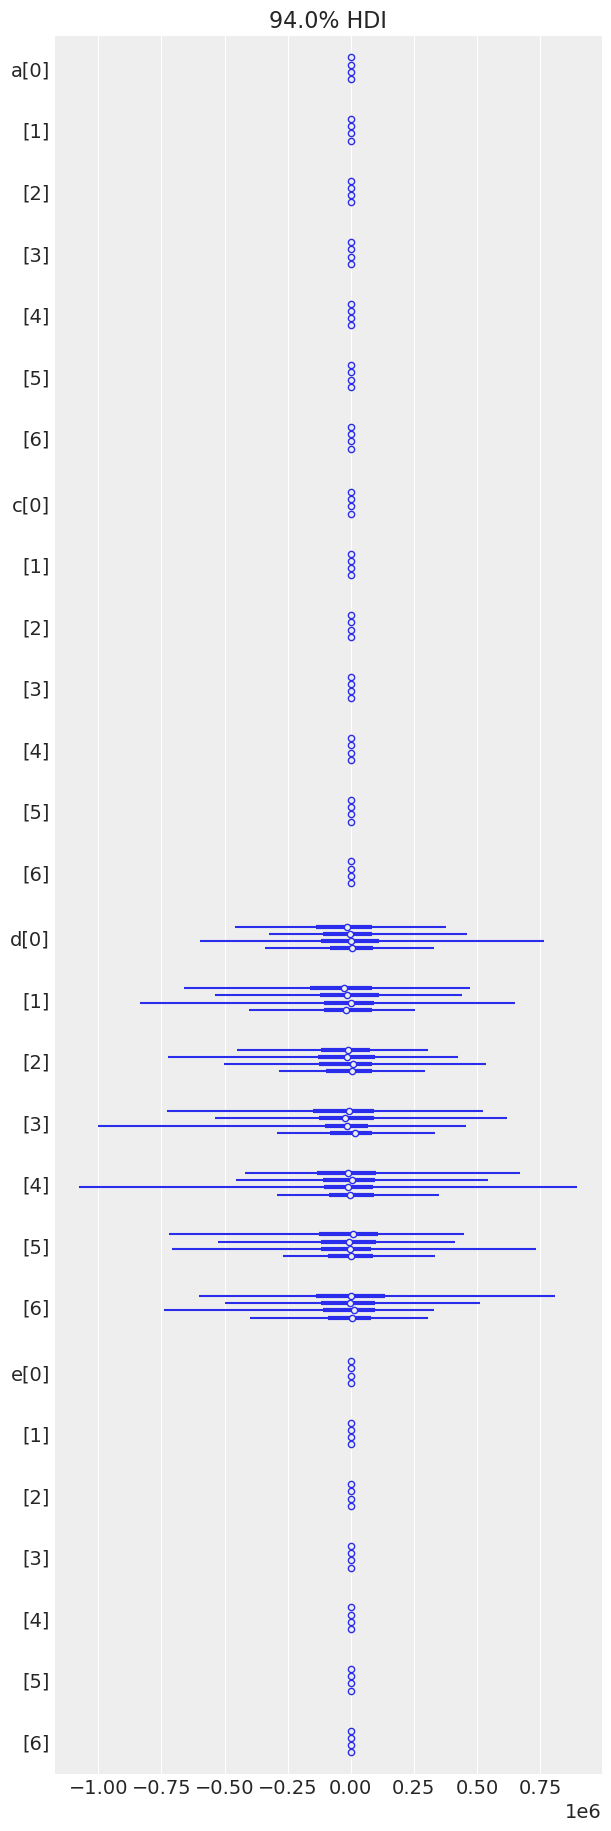

In [140]:
pm.plot_forest(idraw, var_names=['a', 'c', 'd', 'e'])

In [1]:
trace.varnames

NameError: name 'trace' is not defined

In [155]:
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['fantasy_points']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('fantasy_points')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    # Prediction information
    print('True Grade = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))


In [158]:
test_model(idraw, test.iloc[41])

Test Observation:
Unnamed: 0                         48835
game_id                     202111210LAC
player_id                       mannte01
starter                                0
mp                                 27:00
did_not_play                           0
is_inactive                            0
fantasy_points                      11.8
player_name                 Terance Mann
position                              SG
team                                 LAC
opponent                             DAL
teamscore                             97
opponentscore                         91
date                                1121
avg_pts                            18.68
10_game_average                    18.68
10_game_average_position            19.8
Name: 18219, dtype: object


AttributeError: 'InferenceData' object has no attribute 'varnames'

In [159]:
np.random.seed(1)
with model:
    pm.set_data({'data': x_test})
    y_pred = pm.sample_posterior_predictive(idraw)
    
preds = np.array(y_pred.posterior_predictive['y_hat'].mean(('chain', 'draw')))
preds

KeyError: 'data'